# Fit using paw law

In [11]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [12]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T_{\max}} = \frac{a_1}{\left(1 + a_2*\left(\frac{1}{n_v}\right)^{a_3} \right)} $$ 

In [47]:
# def model_function(x: float,a1: float,a2: float,a3: float,a4: float):
#     return a1 + a2*(x) + a3*(x)**a4

def model_function(x: float,a1: float,a2: float,a3: float):
    return a1*(1/(1 + a2*(x**a3)))

               
# def model_function(x: float,a1: float,a2: float,a3: float):
#     return a1*(1/(1 + a2*np.exp(a3*np.log(x))))

In [42]:
# def get_extrapol_function(model_function,a1,a2,a3,a4):
#     def extrapol_funct(x):
#         return model_function(x,a1,a2,a3,a4)
#     return extrapol_funct

def get_extrapol_function(model_function,a1,a2,a3):
    def extrapol_funct(x):
        return model_function(x,a1,a2,a3)
    return extrapol_funct

## Read files

In [37]:
data_path = Path("../../data/regular/infinite-size").resolve()
file = 'regular_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [38]:
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.671622,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.516743,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.438057,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.389057,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.354681,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.328996,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.308949,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.292798,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.279327,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.267970,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [43]:
df_params = pd.DataFrame(index=["a1","a2","a3"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

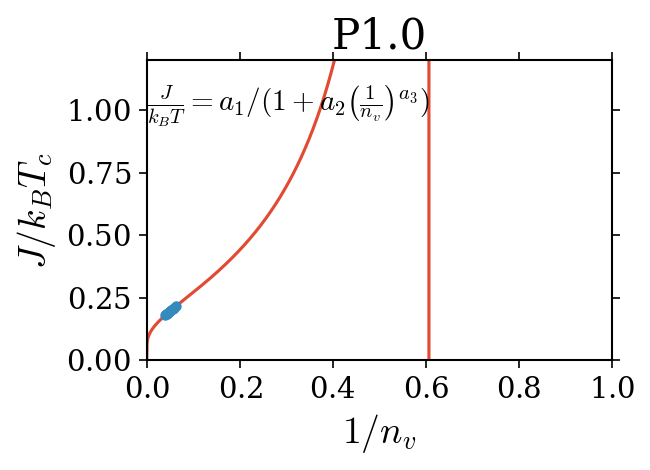

a1: 6.558089214998374e-05
a2: -1.0000670842752948
a3: 0.00013408140686760618
Extrapolation:
6.558089214998374e-05 at 1/nv=0
-0.9775896342594134 at 1/nv=1
min:-745.7559295496939 at 0.6067415730337078




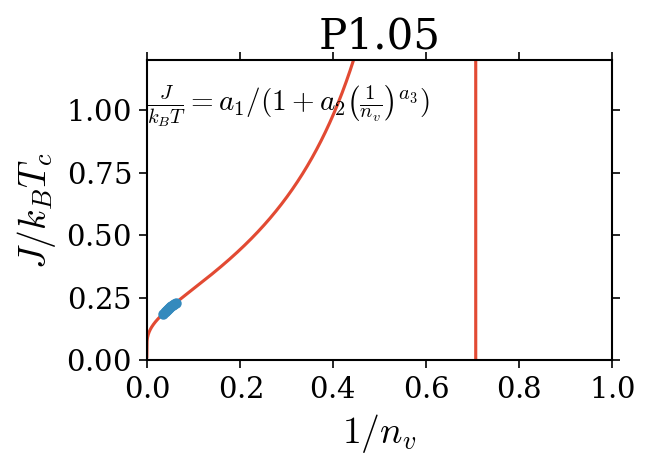

a1: 0.00011596429906631127
a2: -1.0000721816769862
a3: 0.00020814914611864366
Extrapolation:
0.00011596429906631127 at 1/nv=0
-1.6065614420193057 at 1/nv=1
min:-970.411070373014 at 0.7073766487542745




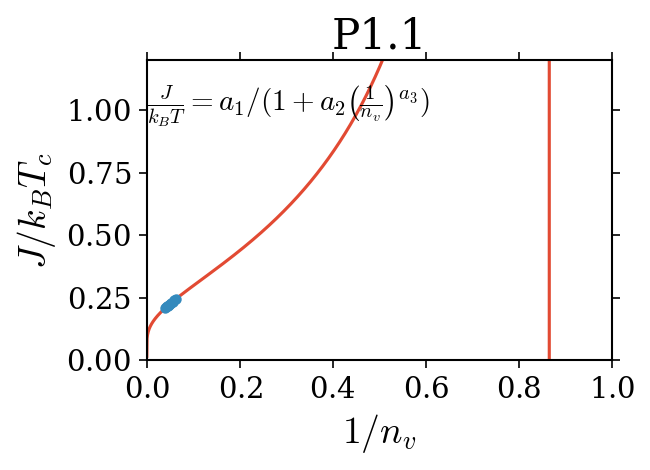

a1: 0.00028620986816206816
a2: -1.0000644405291919
a3: 0.00044564674069980873
Extrapolation:
0.00028620986816206816 at 1/nv=0
-4.441457445359397 at 1/nv=1
min:-1952.61452713004 at 0.865657059110894




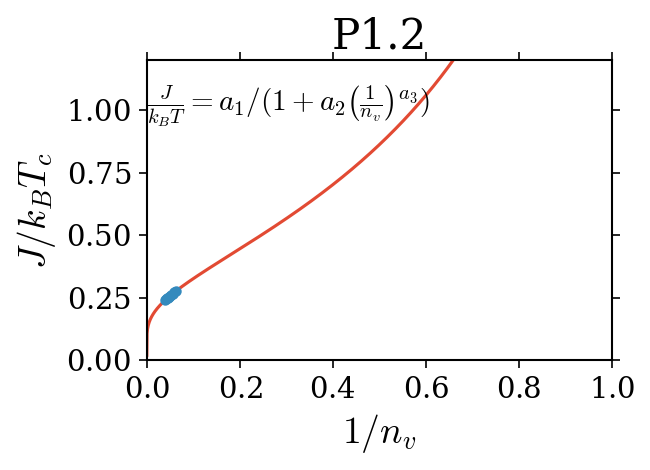

a1: 0.00024025060725196671
a2: -0.9999186720536992
a3: 0.0002847871817909348
Extrapolation:
0.00024025060725196671 at 1/nv=0
2.954096570488008 at 1/nv=1
min:0.019278324201635392 at 1e-19




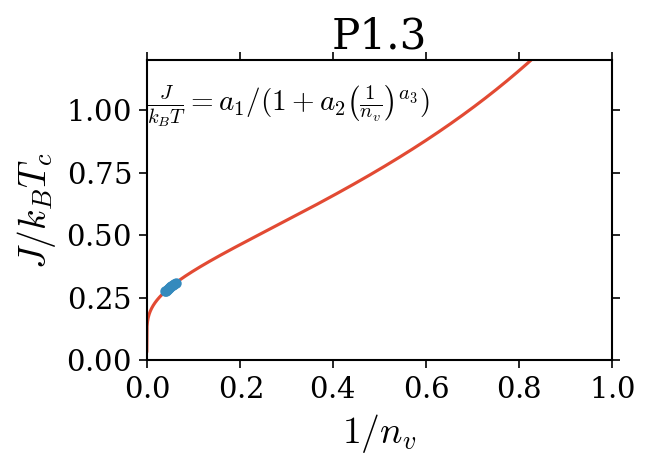

a1: 0.02245393263033056
a2: -0.9853993670029046
a3: 0.021858106768389816
Extrapolation:
0.02245393263033056 at 1/nv=0
1.5378739151102245 at 1/nv=1
min:0.03614089908043999 at 1e-19




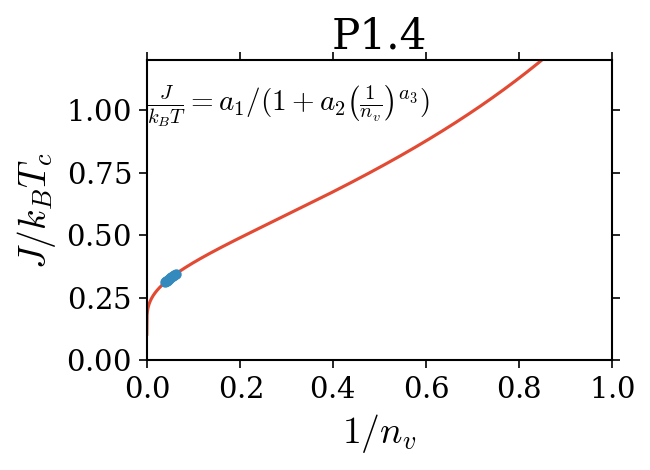

a1: 0.10227528876485095
a2: -0.9299764070145119
a3: 0.10065863536990254
Extrapolation:
0.10227528876485095 at 1/nv=0
1.4605832749263064 at 1/nv=1
min:0.10345207358857055 at 1e-19




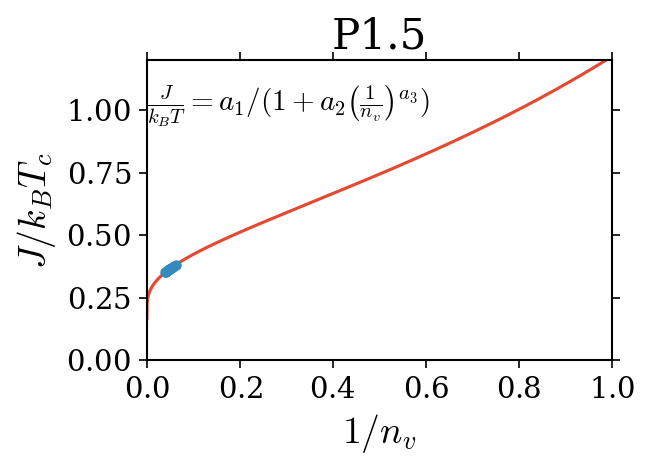

a1: 0.16445805476694209
a2: -0.8646633815259707
a3: 0.15064282897230952
Extrapolation:
0.16445805476694209 at 1/nv=0
1.2151778034745346 at 1/nv=1
min:0.16465358075823242 at 1e-19




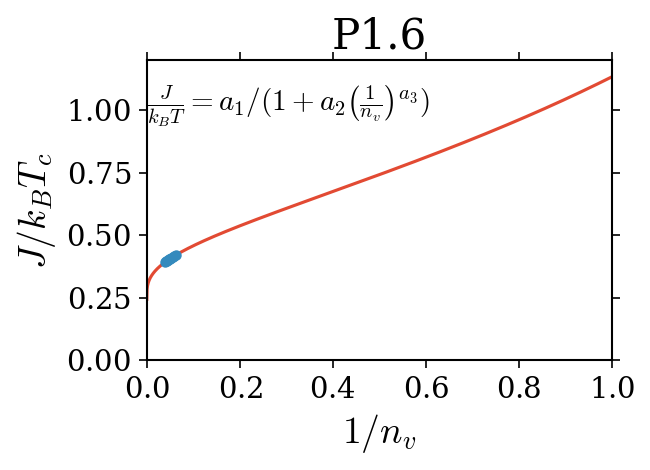

a1: 0.24306553232508027
a2: -0.7855758770173193
a3: 0.22432145679791135
Extrapolation:
0.24306553232508027 at 1/nv=0
1.1335736340855316 at 1/nv=1
min:0.24307597525820054 at 1e-19




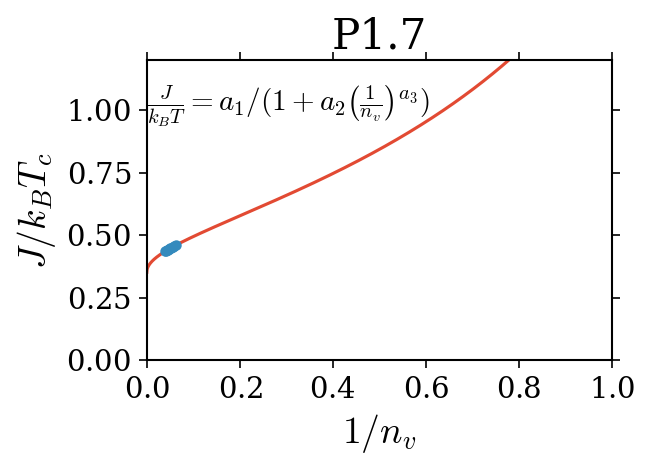

a1: 0.35131511404687804
a2: -0.7889694127964582
a3: 0.43550261833538745
Extrapolation:
0.35131511404687804 at 1/nv=0
1.6647592119337178 at 1/nv=1
min:0.3513151155198933 at 1e-19




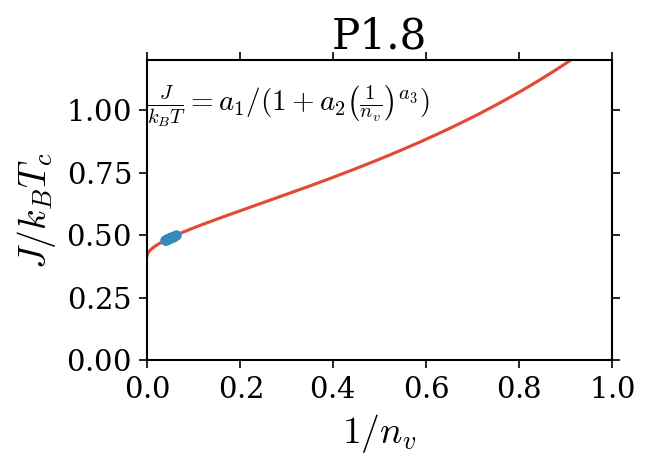

a1: 0.4143693836456848
a2: -0.6860313855032119
a3: 0.5018771453582689
Extrapolation:
0.4143693836456848 at 1/nv=0
1.3197796356486573 at 1/nv=1
min:0.41436938372849164 at 1e-19




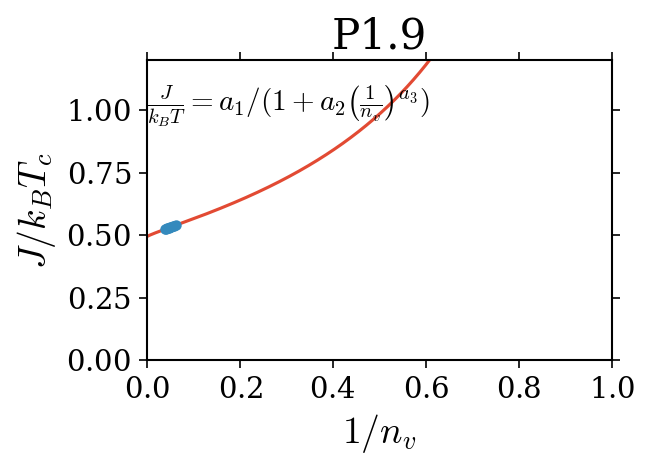

a1: 0.4939151459104166
a2: -0.8997107496639075
a3: 0.8526845035121128
Extrapolation:
0.4939151459104166 at 1/nv=0
4.924906151508687 at 1/nv=1
min:0.4939151459104167 at 1e-19




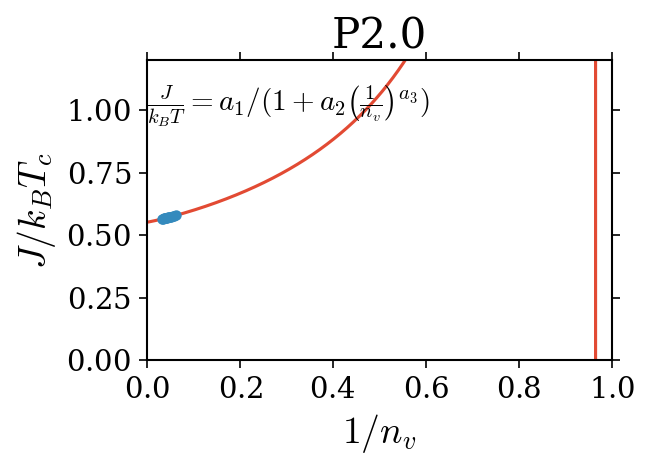

a1: 0.5516534477024553
a2: -1.04034836451882
a3: 1.1144563491102968
Extrapolation:
0.5516534477024553 at 1/nv=0
-13.672262910313066 at 1/nv=1
min:-2571.229304261104 at 0.9653150952613581




In [59]:
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
min_nv = 15
path_save_graph = Path("../../graphs/h-1").resolve()
# file_name_base = 'inv_Tc_vs_inv_nv_extrapol_linear_and_power_law_3_parms'
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_and_power_law_referee_3_parms_{}_nv_v2'.format(min_nv)
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values[min_nv-1:]
    y_data = df_part[COLUMN].values[min_nv-1:]
    # add value at nv=1
    if min_nv == 1: 
        x_data = np.concatenate([x_data,[1]])
        y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0)
#         y_data = np.insert(y_data,0,0)

#     # for square
#     y_data = y_data**2    

    (a1,a2,a3), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,
                             maxfev=10000,
                             p0=[0.3, -0.5, 0.5],
#                                bounds=([0, -0.99, -1], [1, 0, 1])
                               )
    df_params[COLUMN] = [a1,a2,a3]
    extrapol_funct = get_extrapol_function(model_function, a1, a2,a3)

    
    # define the point for graph
    x_extrapol = np.linspace(1E-19, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1/(1 + a_2 \left(\frac{1}{n_v}\right)^{a_3})$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.xlim([0,1])
    pyplot.ylim([0,1.2])
    pyplot.show()
    print("a1: {}\na2: {}\na3: {}".format(a1,a2,a3))
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(extrapol_funct(0),extrapol_funct(1)))
    df_extrapol_val[COLUMN] = [extrapol_funct(0),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")
#     if COLUMN == "P1.1":
#         break


In [11]:
0.0001**0.06595614116937931

0.5447226517117655

## Save params

In [60]:
print(data_path)
file_name_base

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size


'inv_Tc_vs_inv_nv_extrapol_and_power_law_referee_3_parms_15_nv_v2'

In [61]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
a1  0.000066  0.000116  0.000286  0.000240  0.022454  0.102275  0.164458   
a2 -1.000067 -1.000072 -1.000064 -0.999919 -0.985399 -0.929976 -0.864663   
a3  0.000134  0.000208  0.000446  0.000285  0.021858  0.100659  0.150643   

        P1.6      P1.7      P1.8      P1.9      P2.0  
a1  0.243066  0.351315  0.414369  0.493915  0.551653  
a2 -0.785576 -0.788969 -0.686031 -0.899711 -1.040348  
a3  0.224321  0.435503  0.501877  0.852685  1.114456  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\Extrapolation\inv_Tc_vs_inv_nv_extrapol_and_power_law_referee_3_parms_15_nv_v2_params_curves.csv
           P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
infty  0.000066  0.000116  0.000286  0.000240  0.022454  0.102275  0.164458   
1     -0.977590 -1.606561 -4.441457  2.954097  1.537874  1.460583  1.215178   

 

## Plot extrapol values

Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\h-1\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_power_law_4_parms_all_p.png


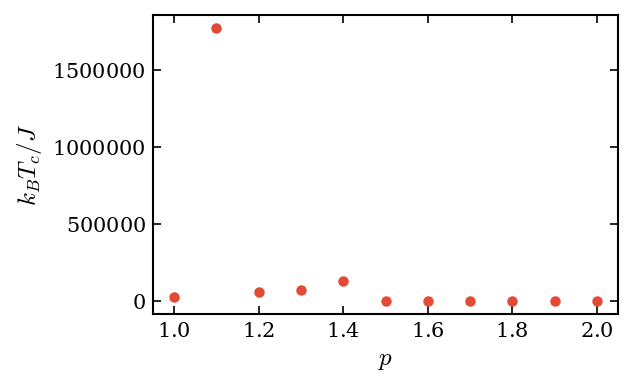

In [17]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# data for squared 
y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=0)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()